### Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

### Load data 

In [2]:
train = pd.read_csv('../app/src/data/train.csv')
test = pd.read_csv('../app/src/data/test.csv')

In [3]:
train.shape

(891, 12)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Williams-Lambert, Mr. Fletcher Fellows",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


### Exploration

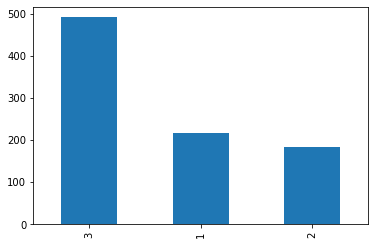

In [9]:
train['Pclass'].value_counts().plot(kind='bar');

In [10]:
train.groupby(['Pclass'],as_index=False).agg({'Survived': 'mean'}).sort_values(by='Survived',ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


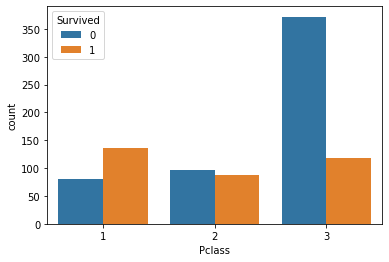

In [11]:
sns.countplot(data=train, hue='Survived', x='Pclass');

In [12]:
train.groupby(['Sex'],as_index=False).agg({'Survived': 'mean'}).sort_values(by='Survived',ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


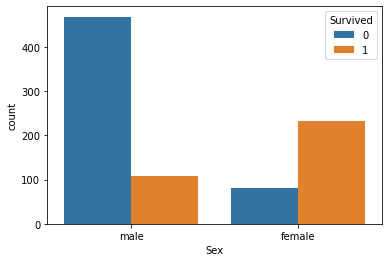

In [13]:
sns.countplot(data=train, hue='Survived', x='Sex');

In [14]:
train.groupby(['SibSp'],as_index=False).agg({'Survived': 'mean'}).sort_values(by='Survived',ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


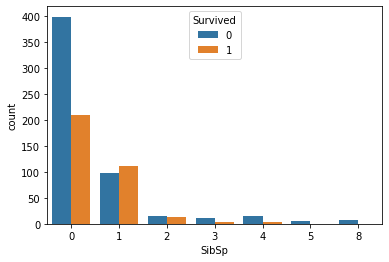

In [15]:
sns.countplot(data=train, hue='Survived', x='SibSp');

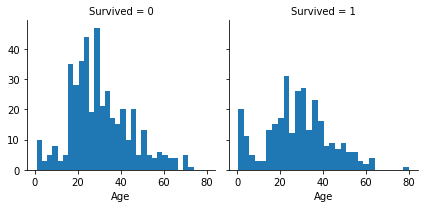

In [16]:
g=sns.FacetGrid(train, col='Survived')
g.map(plt.hist,'Age',bins=30);

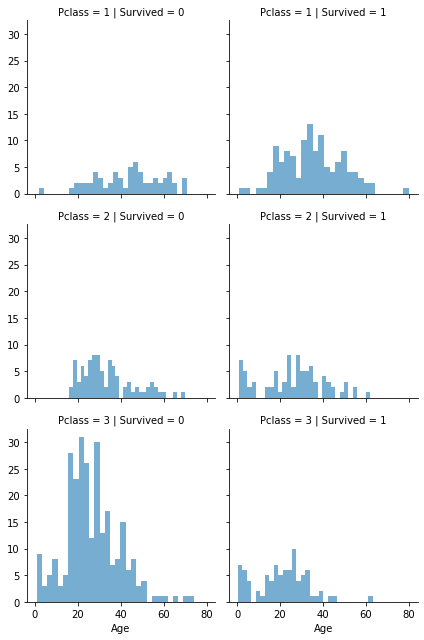

In [17]:
g=sns.FacetGrid(train, row='Pclass', col='Survived')
g.map(plt.hist,'Age',bins=30, alpha=0.6);

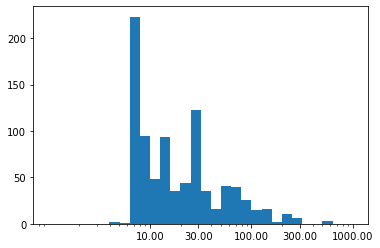

In [18]:
bins = 10**np.arange(0, 3+0.1, 0.1)
ticks = [10,30,100,300,1000]
labels = ['{:0.2f}'.format(t) for t in ticks]
plt.hist(train['Fare'], bins=bins)
plt.xscale('log');
plt.xticks(ticks, labels);

#### Checking Null Values

There are null values in the Age, Cabin and Embarked 

In [19]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [20]:
def impute_missing_values(df, cols, is_numeric=False):
    '''
    Imputing Missing Values, Numeric with median, Categorical with Mode
    args:df : data frame
        col: list of column names
        is_numeric : Boolean
    return -- dataframe
    '''
    for col in cols:
        if is_numeric:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
        
    return df

In [21]:
def normalize_columns(data_frame, columns):
    '''Normalizing columns
    args:
        data_frame : data frame
        columns: list of column names
    return -- dataframe
        '''
    for column in columns:
        mean = data_frame[column].mean()
        std = data_frame[column].std()
        if std != 0:
            data_frame[column] = (data_frame[column] - mean) / std
        else:
            data_frame[column] = 0.0
    return data_frame

In [22]:
def one_hot_coding(data_frame, columns):
    '''Creating Dummy Columns
    args:
        data_frame : data frame
        columns: list of column names
    return -- dataframe
        '''
    for column in columns:
        data_frame = pd.concat([data_frame, pd.get_dummies(data_frame[column], prefix=column)], axis=1)
        data_frame.drop(column, inplace=True, axis=1)
        
    return data_frame

In [23]:
def prepare_data(data_frame):
    '''
    Data Preparation to feed to the machine laerning model
    '''
    drop_columns = ['Name','SibSp', 'Parch', 'Ticket', 'Cabin','PassengerId']
    data_frame = data_frame.drop(columns=drop_columns)
    data_frame = impute_missing_values(data_frame, ['Age', 'Fare'], True)
    data_frame = impute_missing_values(data_frame, ['Embarked'], False)
    data_frame = normalize_columns(data_frame, ['Age', 'Fare'])
    data_frame = one_hot_coding(data_frame, ['Sex', 'Embarked','Pclass'])
    return data_frame

In [24]:
train = prepare_data(train)

In [25]:
X_train, X_test, y_train, y_test= train_test_split(train.drop("Survived", axis=1),train['Survived'],
                                                   test_size=.2, shuffle=True, random_state=42)

In [26]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [27]:
predictions = lr.predict(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       444
           1       0.74      0.70      0.72       268

    accuracy                           0.79       712
   macro avg       0.78      0.78      0.78       712
weighted avg       0.79      0.79      0.79       712



In [28]:
predictions_test = lr.predict(X_test)
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       105
           1       0.76      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [29]:
cross_val_score(lr, X_train, y_train,  cv=5)

array([0.79020979, 0.81118881, 0.76056338, 0.73943662, 0.82394366])

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [31]:
predictions = gb.predict(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       444
           1       0.93      0.78      0.85       268

    accuracy                           0.90       712
   macro avg       0.91      0.87      0.89       712
weighted avg       0.90      0.90      0.90       712



In [32]:
params = [{'learning_rate':[0.01, 0.05, 0.1]},
          {'max_depth':[3,4,5,6]},
          {'n_estimators':range(10, 100, 10)}]

In [33]:
grid_search = GridSearchCV(gb, param_grid=params, cv=10, scoring='accuracy')

In [34]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid=[{'learning_rate': [0.01, 0.05, 0.1]},
                         {'max_depth': [3, 4, 5, 6]},
                         {'n_estimators': range(10, 100, 10)}],
             scoring='accuracy')

In [35]:
final_model = grid_search.best_estimator_

In [36]:
gb.feature_importances_

array([0.14520365, 0.1872243 , 0.16399266, 0.30773085, 0.00422955,
       0.00357057, 0.01469975, 0.02355002, 0.00295954, 0.14683911])

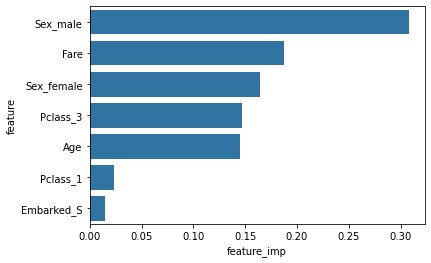

In [37]:
feature_imp = pd.DataFrame({'feature':X_train.columns, 'feature_imp':gb.feature_importances_ })

feature_imp = feature_imp.sort_values(by='feature_imp', ascending=False)

top_features = feature_imp[feature_imp.feature_imp>0.01]

sns.barplot(data=top_features, x='feature_imp', y='feature',
           color = sns.palettes.color_palette()[0]);

In [38]:
test_df = prepare_data(test)

In [40]:
test_df

,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0.385769,-0.496818,0,1,0,1,0,0,0,1
1,1.369729,-0.511665,1,0,0,0,1,0,0,1
2,2.550481,-0.463545,0,1,0,1,0,0,1,0
3,-0.204607,-0.481898,0,1,0,0,1,0,0,1
4,-0.598191,-0.416992,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
413,-0.204607,-0.492865,0,1,0,0,1,0,0,1
414,0.739994,1.312862,1,0,1,0,0,1,0,0
415,0.700636,-0.507189,0,1,0,0,1,0,0,1
416,-0.204607,-0.492865,0,1,0,0,1,0,0,1


In [41]:
predictions = final_model.predict(test_df)

In [43]:
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [1]:
ls

Titanic.ipynb


In [2]:
ls ..

Dockerfile        __pycache__/      model_weights     research/
README.md         app/              requirements.txt  venv/


SyntaxError: invalid syntax (<ipython-input-8-a0878d980c3d>, line 1)

In [9]:
import sys

In [10]:
sys.path

['/Users/kirankumar/Desktop/projects/end_to_end_ml/research',
 '/Users/kirankumar/opt/anaconda3/lib/python38.zip',
 '/Users/kirankumar/opt/anaconda3/lib/python3.8',
 '/Users/kirankumar/opt/anaconda3/lib/python3.8/lib-dynload',
 '',
 '/Users/kirankumar/opt/anaconda3/lib/python3.8/site-packages',
 '/Users/kirankumar/opt/anaconda3/lib/python3.8/site-packages/aeosa',
 '/Users/kirankumar/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions',
 '/Users/kirankumar/.ipython']

In [13]:
sys.path.insert(0,'/Users/kirankumar/Desktop/projects/end_to_end_ml/app/src')

In [12]:
ls

Titanic.ipynb


In [15]:
import train

['/Users/kirankumar/Desktop/projects/end_to_end_ml/app/', '/Users/kirankumar/Desktop/projects/end_to_end_ml/app/src', '/Users/kirankumar/Desktop/projects/end_to_end_ml', '/Users/kirankumar/Desktop/projects/end_to_end_ml/research', '/Users/kirankumar/opt/anaconda3/lib/python38.zip', '/Users/kirankumar/opt/anaconda3/lib/python3.8', '/Users/kirankumar/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/kirankumar/opt/anaconda3/lib/python3.8/site-packages', '/Users/kirankumar/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/kirankumar/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/kirankumar/.ipython']


In [19]:
import os, inspect

In [20]:
os.path.realpath(os.path.abspath(os.path.split(inspect.getfile(inspect.currentframe()))[0]))

'/Users/kirankumar/Desktop/projects/end_to_end_ml/research'

In [21]:
from app.src.train import prepare_data